# Topic Modelling for Comments

In [1]:
!pip install pandas nltk gensim matplotlib wordcloud scikit-learn

In [3]:
# Load the dataset 
import pandas as pd
df = pd.read_csv(r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\NLP Project NYT\nytimes_comments_with_metadata.csv")  

# Display columns to confirm correct extraction
print("Available Columns:", df.columns)

text_column = "commentBody"  # Use comments for analysis


# Drop missing values in the selected text column
df = df.dropna(subset=[text_column])

# Show a sample of extracted text
print("\nSample Text for Topic Modeling:\n", df[text_column].head())

Available Columns: Index(['article_url', 'article_title', 'status', 'commentSequence', 'userID',
       'userDisplayName', 'userLocation', 'userTitle', 'userURL', 'picURL',
       'commentTitle', 'commentBody', 'createDate', 'updateDate',
       'approveDate', 'recommendations', 'replyCount', 'editorsSelection',
       'parentID', 'parentUserDisplayName', 'depth', 'commentType', 'trusted',
       'recommendedFlag', 'permID', 'isAnonymous'],
      dtype='object')

Sample Text for Topic Modeling:
 0    A truly enlightened society would be investing...
1    @-dz I agree, but people still need to get to ...
2    @-dz - No, this is not North Korea. Yes, publi...
3    @Andy Cars offer a lot less freedom than peopl...
4    @jeepCK \n\nA trult enlightened society would ...
Name: commentBody, dtype: object


### Step 2: Preprocess the Text ###
We'll:

- Convert to lowercase
- Remove stopwords, punctuation, and numbers
- Lemmatize words (convert to root form)

In [4]:
import nltk

# Download missing tokenizer resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Ensures WordNet lemmatizer works correctly

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...


True

In [5]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):  # Ensure text is a string
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\W', ' ', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        words = word_tokenize(text)  # Tokenize words
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  
        return " ".join(words)
    else:
        return ""  # Return empty string if NaN or not text

# **Apply preprocessing to the dataset**
df["clean_text"] = df[text_column].apply(preprocess_text)

# Check the cleaned text
print("\nCleaned Text Sample:\n", df[["clean_text"]].head())


Cleaned Text Sample:
                                           clean_text
0  truly enlightened society would investing far ...
1  agree people still need get train station live...
2  north korea yes public transport improved disc...
3  andy car offer lot less freedom people like pr...
4  jeepck trult enlightened society would also us...


### Step 3: Convert Text to Numerical Representation (TF-IDF) ###
We'll use TF-IDF Vectorization to convert text into a numerical format

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert text into a bag-of-words model
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
X = vectorizer.fit_transform(df["clean_text"])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

### Step 4: Apply LDA for Topic Modeling ###
Now, let's extract topics from the text.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

# Set number of topics
num_topics = 5  # You can experiment with different numbers

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display Topics
def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

display_topics(lda, feature_names)


Topic 1:
car, charging, station, charge, mile, people, electric, need, gas, home

Topic 2:
electric, power, energy, car, battery, fuel, electricity, vehicle, emission, gas

Topic 3:
change, climate, people, tax, ev, year, time, government, state, world

Topic 4:
car, electric, vehicle, cost, year, new, price, battery, gas, ev

Topic 5:
republican, like, car, biden, people, market, want, make, american, think


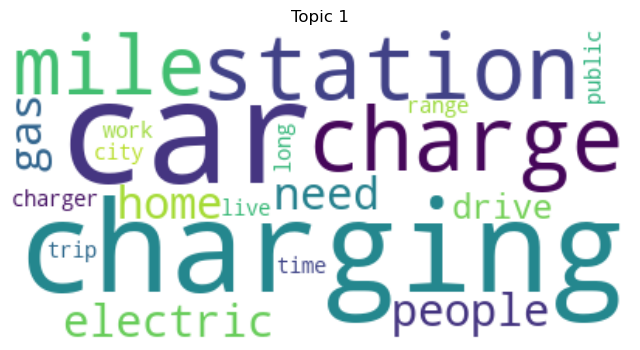

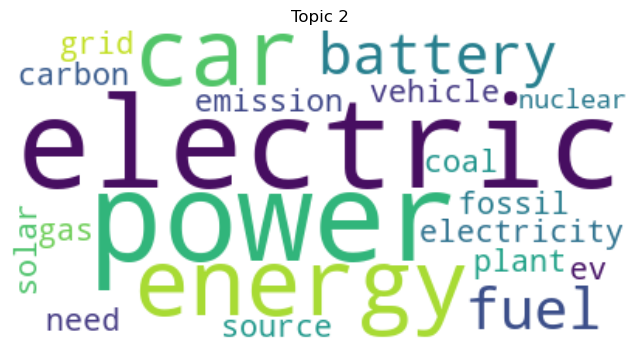

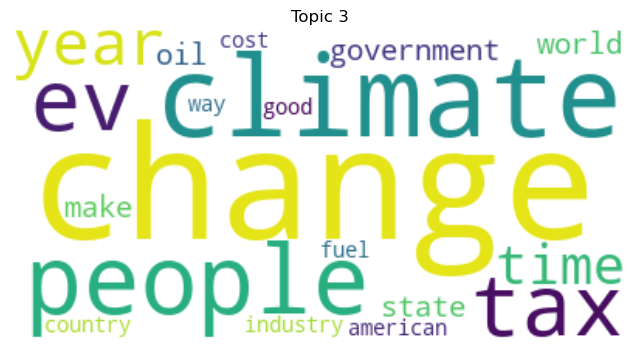

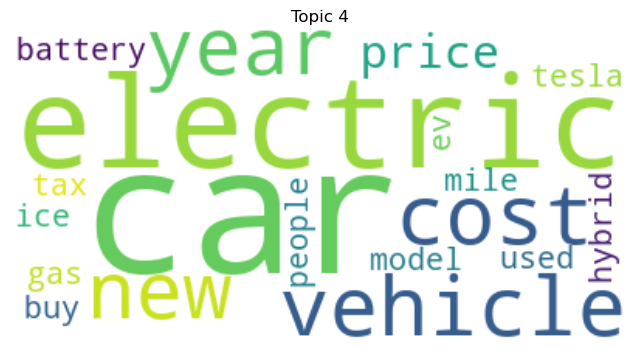

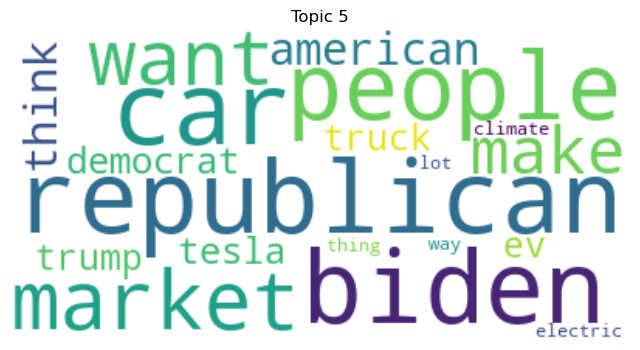

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(background_color="white").generate(" ".join([feature_names[i] for i in topic.argsort()[:-20 - 1:-1]]))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()


### Topic Modelling For Articles ###

### Step 1: Load ###

In [9]:
import pandas as pd

# Load dataset
df_articles = pd.read_csv(r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\NLP Project NYT\ev_articles_metadata.csv")


# Display available columns
print("Available columns:", df_articles.columns)

Available columns: Index(['URL', 'Headline', 'Abstract', 'Lead Paragraph', 'Publication Date'], dtype='object')


### Step 2: Combine Relevant Text Columns ###
Since we don't have the full article text, we will merge headline, abstract, snippet, and lead_paragraph.

In [10]:
# Ensure we only use text-based columns
df_articles["combined_text"] = df_articles[["Headline", "Abstract", "Lead Paragraph"]].astype(str).agg(" ".join, axis=1)

# Drop missing values
df_articles = df_articles.dropna(subset=["combined_text"])

### Step 3: Preprocess the Text ###
We remove stopwords, punctuation, and lemmatize for better topic modeling.

In [11]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = word_tokenize(text)  # Tokenize words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

# Apply preprocessing
df_articles["clean_text"] = df_articles["combined_text"].apply(preprocess_text)

# Save cleaned data for reference
df_articles.to_csv(r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\NLP Project NYT\ev_articles_cleaned_1.csv", index=False)

# Display first 5 cleaned rows
print(df_articles[["clean_text"]].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


                                          clean_text
0  main trump first two week thrown climate spend...
1  main pif effect pioneering investment kicker n...
2  main letter caroline ellison parent judge kapl...
3  main electric vehicle gain access tesla charge...
4  main transcript ezra klein interview matthew y...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Step 4: Convert Text to Numerical Format (TF-IDF) ###
We vectorize the text using CountVectorizer before applying LDA topic modeling.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert text into a bag-of-words model
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
X = vectorizer.fit_transform(df_articles["clean_text"])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

### Step 5: Apply LDA for Topic Modeling ###
Now, let's extract key topics.

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

# Set number of topics
num_topics = 5  # Experiment with different values

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display Topics
def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🔹 Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

display_topics(lda, feature_names)



🔹 Topic 1:
year, tesla, car, climate, biden, trump, president, day, republican, owner

🔹 Topic 2:
need, global, world, climate, report, tech, change, know, battle, fight

🔹 Topic 3:
future, episode, nan, mobility, smart, taiwan, introducing, shaping, innovator, driving

🔹 Topic 4:
electric, charging, vehicle, car, new, charger, tesla, sale, company, battery

🔹 Topic 5:
electric, car, vehicle, new, charging, tesla, model, charge, technology, ford


### Step 6: Visualize Topics with WordCloud ###

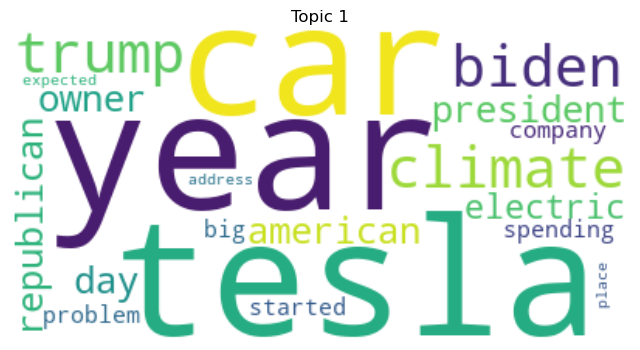

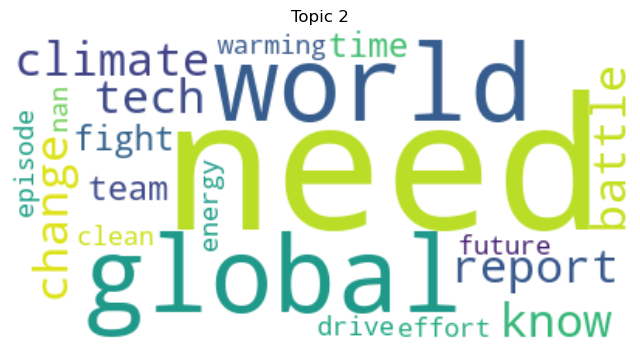

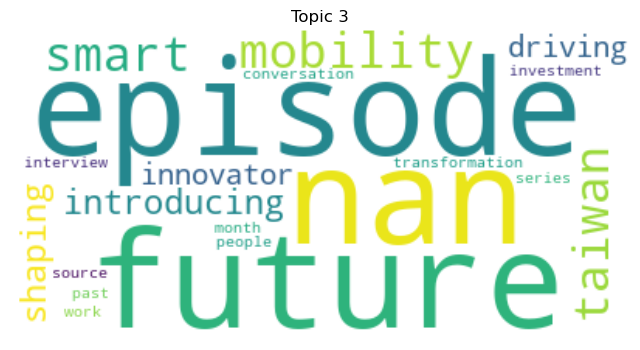

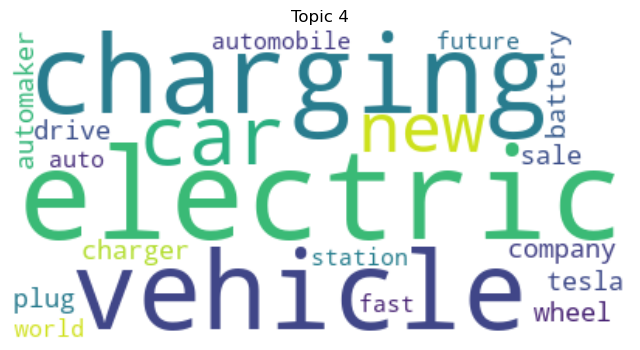

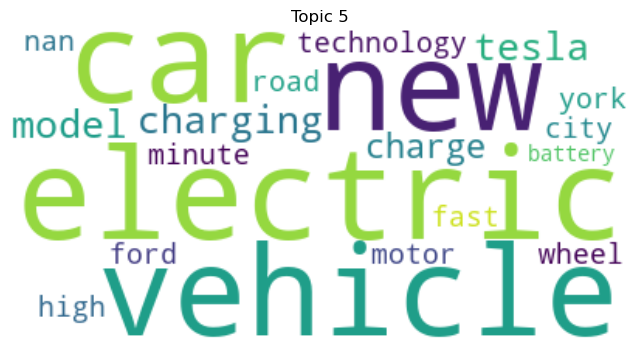

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(background_color="white").generate(" ".join([feature_names[i] for i in topic.argsort()[:-20 - 1:-1]]))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()


### Relating Topic Modelling for Articles and Comments ###

### Step 1: Load Processed Data ###

In [16]:
import pandas as pd

# Load cleaned article data
df_articles = pd.read_csv(r"C:\Users\USER\OneDrive - Institute of Business Administration\Desktop\NLP Project NYT\ev_articles_cleaned_1.csv")

# Load cleaned comment data
df_comments = df

# Display first few rows
print("\n📌 Articles Data Sample:\n", df_articles[["clean_text"]].head())
print("\n📌 Comments Data Sample:\n", df_comments[["clean_text"]].head())


📌 Articles Data Sample:
                                           clean_text
0  main trump first two week thrown climate spend...
1  main pif effect pioneering investment kicker n...
2  main letter caroline ellison parent judge kapl...
3  main electric vehicle gain access tesla charge...
4  main transcript ezra klein interview matthew y...

📌 Comments Data Sample:
                                           clean_text
0  truly enlightened society would investing far ...
1  agree people still need get train station live...
2  north korea yes public transport improved disc...
3  andy car offer lot less freedom people like pr...
4  jeepck trult enlightened society would also us...


### Step 2: Convert Text into Numerical Format ###
We'll vectorize the text separately for articles and comments.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert articles into a bag-of-words model
vectorizer_articles = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
X_articles = vectorizer_articles.fit_transform(df_articles["clean_text"])
article_feature_names = vectorizer_articles.get_feature_names_out()

# Convert comments into a bag-of-words model
vectorizer_comments = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
X_comments = vectorizer_comments.fit_transform(df_comments["clean_text"])
comment_feature_names = vectorizer_comments.get_feature_names_out()

### Step 3: Apply LDA to Articles & Comments ###

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 5  # Number of topics to extract

# Apply LDA to Articles
lda_articles = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_articles.fit(X_articles)

# Apply LDA to Comments
lda_comments = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_comments.fit(X_comments)

LatentDirichletAllocation(n_components=5, random_state=42)

### Step 4: Compare Topics by Keywords ###

In [19]:
def display_topics(model, feature_names, num_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_keywords = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics.append(topic_keywords)
        print(f"\n🔹 Topic {topic_idx + 1}: {', '.join(topic_keywords)}")
    return topics

# Extract topics
print("\n📰 Articles Topics:")
article_topics = display_topics(lda_articles, article_feature_names)

print("\n💬 Comments Topics:")
comment_topics = display_topics(lda_comments, comment_feature_names)


📰 Articles Topics:

🔹 Topic 1: year, tesla, car, climate, biden, trump, president, day, republican, owner

🔹 Topic 2: need, global, world, climate, report, tech, change, know, battle, fight

🔹 Topic 3: future, episode, nan, mobility, smart, taiwan, introducing, shaping, innovator, driving

🔹 Topic 4: electric, charging, vehicle, car, new, charger, tesla, sale, company, battery

🔹 Topic 5: electric, car, vehicle, new, charging, tesla, model, charge, technology, ford

💬 Comments Topics:

🔹 Topic 1: car, electric, power, solar, http, electricity, charging, battery, www, gas

🔹 Topic 2: car, electric, people, new, vehicle, price, year, gas, need, buy

🔹 Topic 3: battery, vehicle, cost, electric, car, year, gas, ice, ev, time

🔹 Topic 4: fuel, climate, fossil, change, energy, republican, emission, ev, make, carbon

🔹 Topic 5: charging, car, mile, station, charge, tax, gas, tesla, range, electric


### Step 5: Compute Similarity Between Topics ###

In [25]:
 from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# **Fit CountVectorizer on both articles and comments together**
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")

# Fit on combined data and then transform separately
vectorizer.fit(pd.concat([df_articles["clean_text"], df_comments["clean_text"]], axis=0))

# Transform articles and comments separately, ensuring the same feature space
X_articles = vectorizer.transform(df_articles["clean_text"])
X_comments = vectorizer.transform(df_comments["clean_text"])

# **Compute cosine similarity**
similarity_matrix = cosine_similarity(X_articles, X_comments)

# **Convert to DataFrame**
df_similarity = pd.DataFrame(similarity_matrix, 
                             index=[f"Article {i+1}" for i in range(X_articles.shape[0])],
                             columns=[f"Comment {i+1}" for i in range(X_comments.shape[0])])

# **Display the similarity matrix**
print("\n📊 Topic Similarity Matrix:")
print(df_similarity)




📊 Topic Similarity Matrix:
            Comment 1  Comment 2  Comment 3  Comment 4  Comment 5  Comment 6  \
Article 1    0.000000   0.000000   0.028849   0.000000   0.000000   0.022076   
Article 2    0.000000   0.000000   0.092524   0.000000   0.000000   0.000000   
Article 3    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Article 4    0.170783   0.184226   0.113790   0.081992   0.106479   0.000000   
Article 5    0.000000   0.000000   0.000000   0.028583   0.000000   0.033113   
Article 6    0.158750   0.102748   0.067310   0.035567   0.055427   0.000000   
Article 7    0.156250   0.084275   0.079500   0.052511   0.081832   0.000000   
Article 8    0.060634   0.098110   0.000000   0.000000   0.000000   0.000000   
Article 9    0.060193   0.000000   0.000000   0.000000   0.000000   0.000000   
Article 10   0.000000   0.028748   0.022599   0.029854   0.046524   0.000000   
Article 11   0.000000   0.000000   0.023131   0.000000   0.000000   0.000000   
Article 12  

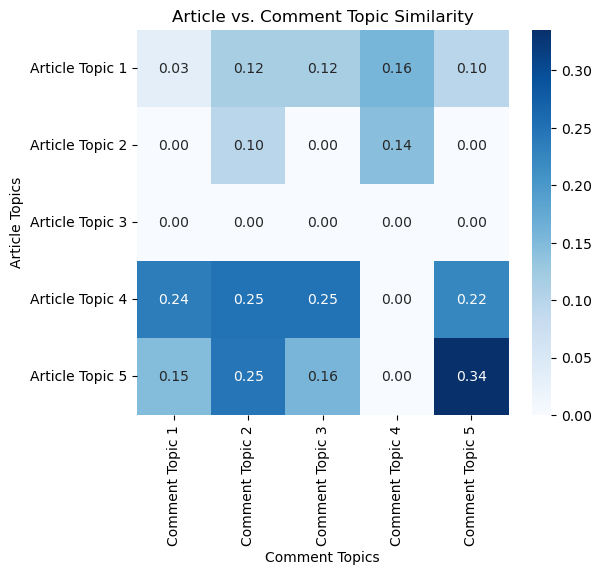


✅ Saved as 'topic_similarity_matrix.csv'


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Step 1: Convert LDA topics into text format**
article_topic_strings = [" ".join(topic) for topic in article_topics]
comment_topic_strings = [" ".join(topic) for topic in comment_topics]

# **Step 2: Vectorize topics using TF-IDF**
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(article_topic_strings + comment_topic_strings)

# **Step 3: Compute cosine similarity between article topics & comment topics**
X_articles = X[:len(article_topics)]  # Article topic vectors
X_comments = X[len(article_topics):]  # Comment topic vectors
similarity_matrix = cosine_similarity(X_articles, X_comments)

# **Step 4: Convert to DataFrame**
df_similarity = pd.DataFrame(similarity_matrix, 
                             index=[f"Article Topic {i+1}" for i in range(len(article_topics))],
                             columns=[f"Comment Topic {i+1}" for i in range(len(comment_topics))])

# **Step 5: Generate Heatmap**
plt.figure(figsize=(6,5))
sns.heatmap(df_similarity, annot=True, cmap="Blues", fmt=".2f")
plt.title("Article vs. Comment Topic Similarity")
plt.xlabel("Comment Topics")
plt.ylabel("Article Topics")
plt.show()

# **Step 6: Save as CSV**
df_similarity.to_csv("topic_similarity_matrix.csv", index=True)
print("\n✅ Saved as 'topic_similarity_matrix.csv'")


### Step 6: Visualize Overlapping & Unique Topics ###

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


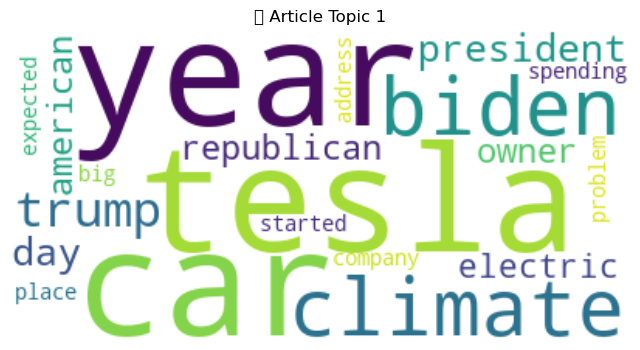

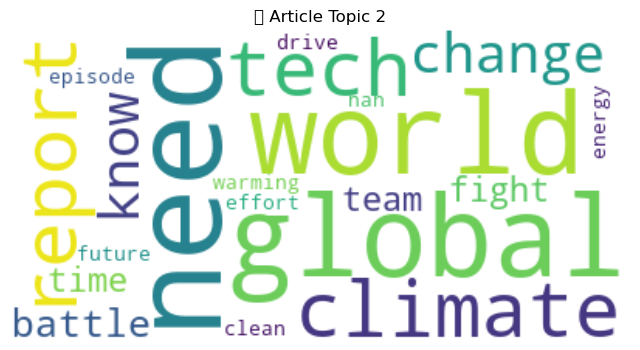

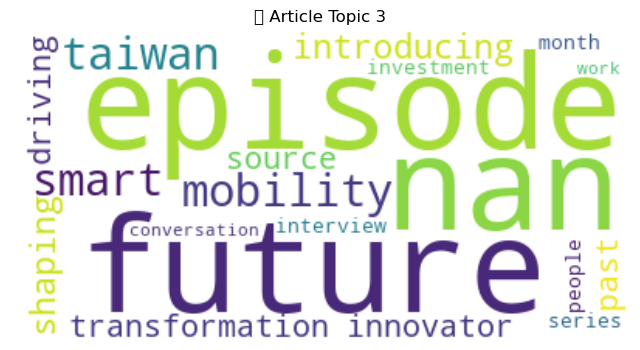

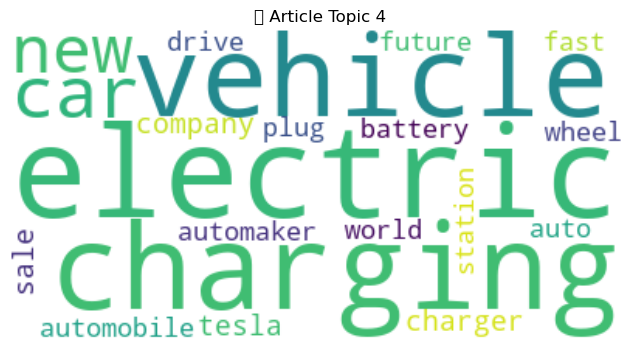

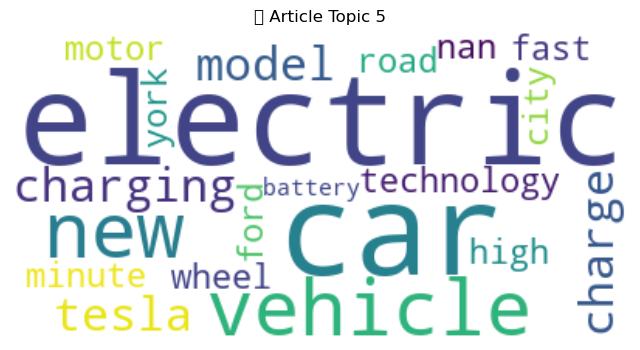

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


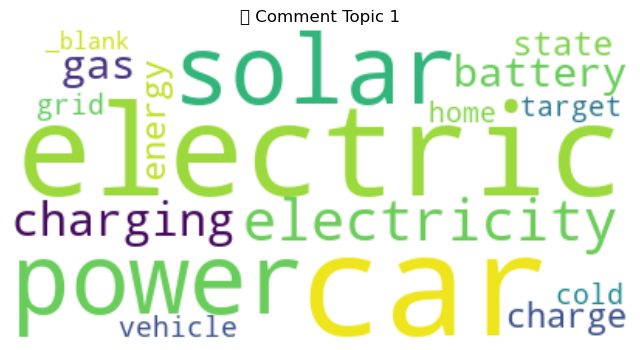

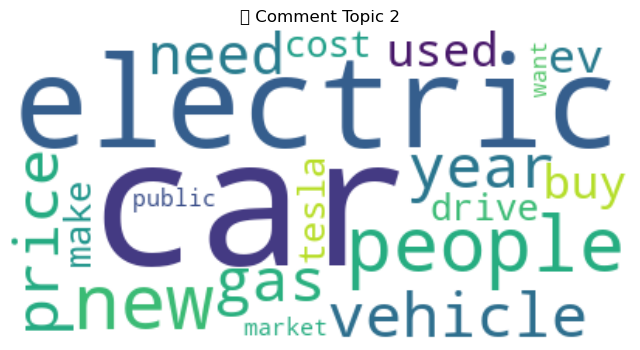

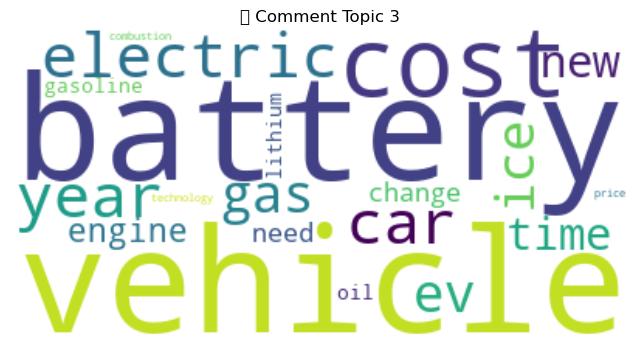

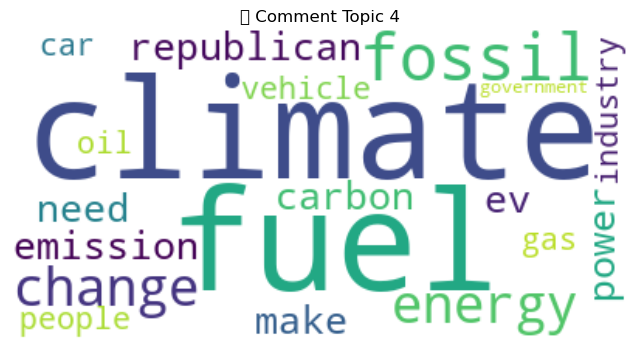

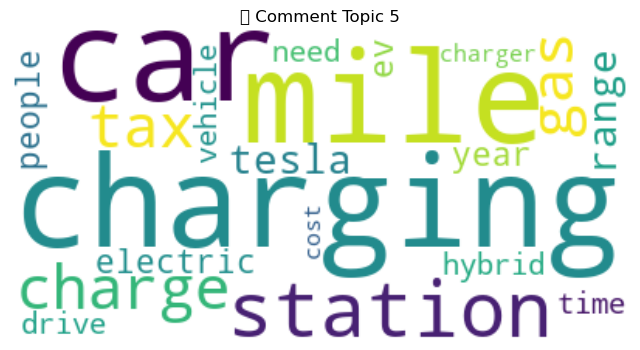

In [27]:
from wordcloud import WordCloud

# Generate word clouds for Articles
for topic_idx, topic in enumerate(lda_articles.components_):
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(background_color="white").generate(" ".join([article_feature_names[i] for i in topic.argsort()[:-20 - 1:-1]]))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"📰 Article Topic {topic_idx + 1}")
    plt.show()

# Generate word clouds for Comments
for topic_idx, topic in enumerate(lda_comments.components_):
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(background_color="white").generate(" ".join([comment_feature_names[i] for i in topic.argsort()[:-20 - 1:-1]]))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"💬 Comment Topic {topic_idx + 1}")
    plt.show()


# NER Technique On Comments

In [2]:
pip install spacy

   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
   ------------- -------------------------- 3.9/11.8 MB 29.4 MB/s eta 0:00:01
   --------------------------- ------------ 8.1/11.8 MB 21.0 MB/s eta 0:00:01
   ---------------------------------------- 11.8/11.8 MB 24.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/632.6 kB ? eta -:--:--
   --------------------------------------- 632.6/632.6 kB 23.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 6.3/6.3 MB 38.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
   ---------------------------------------- 5.4/5.4 MB 47.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ------- -------------------------------- 6.6/33.5 MB 40.3 MB/s eta 0:00:01
     -------------------- ------------------ 17.3/33.5 MB 45.4 MB/s eta 0:00:01
     ------------------------------- ------- 27.3/33.5 MB 45.5 MB/s eta 0:00:01
     --------------------------------------- 33.5/33.5 MB 41.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------- -------------------------- 4.5/12.8 MB 30.0 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 35.8 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 33.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
